In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import random

import torch
import torch.nn as nn
from torch.nn import Parameter
#import torchoptics
#from torchoptics import System
#from torchoptics.elements import PhaseModulator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from matplotlib.colors import hsv_to_rgb
import matplotlib.ticker as ticker

In [2]:
# Check if GPU is registered and being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

devNumber = torch.cuda.current_device()
print(f"The current device number is {devNumber}")

dev_name = torch.cuda.get_device_name(devNumber)
print(f"GPU is {dev_name}")

Using Device: cuda
The current device number is 0
GPU is NVIDIA GeForce RTX 2060


In [3]:
# GLOBAL VARIABLES
pix_size = 1e-5 #[m]
grid_size = 500 # Number of pixels per side of the grid
grid_length = pix_size * grid_size # Length of grid in real space coords
wl = 700e-9 #[m]

In [4]:
# Make a vectorising function
def vectorise(field):
    x = field.shape[0]
    y = field.shape[1]
    return field.reshape(x*y,1)

# Make an unvectorising function
def unvectorise(field, dim):
    return field.reshape(dim,dim)

def Complex2HSV(z, rmin, rmax, hue_start=90):
    # get amplidude of z and limit to [rmin, rmax]
    amp = np.abs(z)
    amp = np.where(amp < rmin, rmin, amp)
    amp = np.where(amp > rmax, rmax, amp)
    ph = np.angle(z, deg=1)# + hue_start
    # HSV are values in range [0,1]
    h = (ph % 360) / 360
    s = 0.85 * np.ones_like(h)
    v = (amp -rmin) / (rmax - rmin)
    return hsv_to_rgb(np.dstack((h,s,v)))

# Make a gaussian function
def gaussian(A, sigma, shape, mux=0, muy=0, warpx=0,warpy=0, B=0):
    """Makes a gaussian tensor of size = shape*shape. Intensity = A. Half-width = sigma. 
    Off-centre with 'mux' and 'muy' (-1 to +1). Or warp the shape with 'warpx' and 'warpy'."""
    X, Y = np.meshgrid(np.linspace((-1-mux)*(1+warpy), (1-mux)*(1+warpy), shape), np.linspace((-1+muy)*(1+warpx), (1+muy)*(1+warpx), shape))
    Z = (X**2 + Y**2)**0.5
    gauss = A * np.exp(-(Z**2)/(2*sigma**2)) + B
    return torch.from_numpy(gauss)

def gaussian_torch(shape, mean, std):
    x, y = np.meshgrid(np.linspace(-1, 1, shape), np.linspace(-1, 1, shape))
    d = np.sqrt(x**2 + y**2)
    gaussian = np.exp(-((d - mean)**2 / (2.0 * std**2)))
    gaussian = torch.from_numpy(gaussian)
    return gaussian

# Make FFT functions
def fft2(field: torch.Tensor) -> torch.Tensor:
    """2D discrete forward fourier transform."""
    return torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(field)))

def ifft2(field: torch.Tensor) -> torch.Tensor:
    """2D discrete inverse fourier transform."""
    return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(field)))

# Make a propagation function using these fft2 functions that works on GPU
def prop(field_in, kz, distance):
    """Propagation of a 2D field using the fft2 functions."""
    field_in_ft = fft2(field_in)
    field_out_ft = field_in_ft * torch.exp(1j*kz*distance)
    field_out = ifft2(field_out_ft)
    return field_out

def find_kz():
    """Generates a kz array for free space propagation."""
    Nx = np.arange(-grid_size/2,grid_size/2,1)
    Ny = np.arange(-grid_size/2,grid_size/2,1)
    X,Y = np.meshgrid(Nx,Ny)
    X = torch.from_numpy(X)
    Y = torch.from_numpy(Y)

    # Make the Kx, Ky and Kz grids.
    # Start with making arrays of the right size to append correct values onto later.
    Kx = np.ones((grid_size,grid_size))
    Ky = np.ones((grid_size,grid_size))

    for y,i in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
        for x,j in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
            Kx[i,j] = (2*np.pi*x)/grid_length
            Ky[i,j] = (2*np.pi*y)/grid_length
    
    Kz = torch.from_numpy(((2*np.pi/wl)**2 - Kx**2 - Ky**2)**0.5)
    return Kz
    
def mseloss(output, target):
    return (output.abs()-target.abs()).abs().square().sum()

def loss_fn(output, target):
    return (output.abs().square() - target.abs().square()).abs().sum()

def loss_func(outputs, targets):
    """Loss function for multiple sets of training data."""
    loss = 0
    for i in range(len(outputs)):
        loss += (outputs[i].abs().square() - targets[i].abs().square()).abs().sum()
    loss /= len(outputs)
    return loss

In [5]:
a = torch.tensor([[1+1j,2,3],[4,5-8j,6],[7,8,9+2j]])
print(a.abs().square().sum())
print(torch.sum(abs(a)**2))

tensor(354.)
tensor(354.)


In [6]:
class Field(torch.Tensor):
    """Class designed around a 2D electric field represented by a torch tensor."""
    wl = 700e-9 #[m]
    k = torch.tensor(2*np.pi/wl) #[1/m]
    k_x = 1235678
    k_y = 3457437
    k_z = (torch.abs(k)**2 - k_x**2 - k_y**2)**0.5 #[1/m]
    
    def __init__(self, tensor):
        self = tensor

    def normalise(self):
        return self / torch.linalg.matrix_norm(self)

    def visualise(self, figsize=(10,5),title=""):
        """Displays a visual plot of the field, using hsv colour mapping to demonstrate the 
        fields phase (Hue) and amplitude (Value)."""
        # Set up plots
        fig, axs = plt.subplots(1,2, figsize=figsize)

        # Plot the given field
        axs[0].imshow(Complex2HSV(self, 0, 0.025))

        # Colour bar
        V, H = np.mgrid[0:1:100j, 0:1:300j]
        S = np.ones_like(V)
        HSV = np.dstack((H,S,V))
        RGB = hsv_to_rgb(HSV)

        axs[1].imshow(RGB, origin="lower", extent=[0, 2*np.pi, 0, 1], aspect=15)

        axs[1].set_xticks([0, np.pi, 2*np.pi], ['0', '$\pi$', '$2\pi$'])
        axs[1].set_yticks([0, 1], ['0', '1'])

        axs[1].set_ylabel("Amplitude")
        axs[1].set_xlabel("Phase (rad.)")

        fig.show()

Text(0.5, 0, '$k_z$')

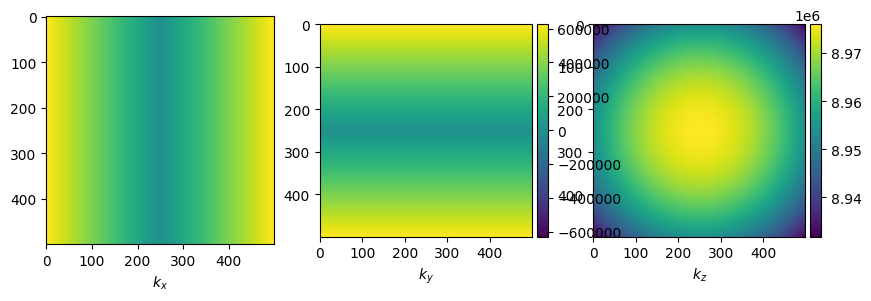

In [39]:
pix_size = 5e-6 #[m]
grid_size = 500 # Number of pixels per side of the grid
grid_length = pix_size * grid_size # Length of grid in real space coords
wl = 700e-9 #[m]
#print(grid_length)

Nx = np.arange(-grid_size/2,grid_size/2,1)
Ny = np.arange(-grid_size/2,grid_size/2,1)
X,Y = np.meshgrid(Nx,Ny)
X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

alpha = torch.tensor(0.05)
beta = torch.tensor(0.05)

# Make the Kx, Ky and Kz grids.
# Start with making arrays of the right size to append correct values onto later.
Kx = np.ones((grid_size,grid_size))
Ky = np.ones((grid_size,grid_size))

for y,i in zip(np.arange(-grid_size//2,grid_size//2,1), np.arange(0,grid_size+1,1)):
    for x,j in zip(np.arange(-grid_size//2,grid_size//2,1), np.arange(0,grid_size+1,1)):
        Kx[i,j] = (2*np.pi*x)/grid_length
        Ky[i,j] = (2*np.pi*y)/grid_length

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
minmin = np.min([np.min(Kx), np.min(Ky)])
maxmax = np.max([np.max(Kx), np.max(Ky)])

#im1 = axs[0].imshow(Kx, vmin=minmin, vmax=maxmax)
#im2 = axs[1].imshow(Ky, vmin=minmin, vmax=maxmax)
im1 = axs[0].imshow(np.abs(Kx), vmin=minmin, vmax=maxmax)
im2 = axs[1].imshow(np.abs(Ky), vmin=minmin, vmax=maxmax)

axs[0].set_xlabel("$k_x$")
axs[1].set_xlabel("$k_y$")

divider1 = make_axes_locatable(axs[1])
divider2 = make_axes_locatable(axs[2])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im2, cax=cax1)

Kz = torch.from_numpy(((2*np.pi/wl)**2 - Kx**2 - Ky**2)**0.5)#.type(torch.cfloat)

im3 = axs[2].imshow(Kz)
plt.colorbar(im3,cax=cax2)
axs[2].set_xlabel("$k_z$")

In [40]:
kX = (torch.arange(-grid_size // 2 + 0.5, grid_size // 2).to(device) / (grid_size * pix_size)) * 2 * np.pi
kX

tensor([-627061.9375, -624548.6250, -622035.3750, -619522.0625, -617008.8125,
        -614495.5625, -611982.2500, -609469.0000, -606955.6875, -604442.4375,
        -601929.1875, -599415.8750, -596902.6250, -594389.3750, -591876.0625,
        -589362.8125, -586849.5000, -584336.2500, -581823.0000, -579309.6875,
        -576796.4375, -574283.1250, -571769.8750, -569256.6250, -566743.3125,
        -564230.0625, -561716.8125, -559203.5000, -556690.2500, -554176.9375,
        -551663.6875, -549150.4375, -546637.1250, -544123.8750, -541610.5625,
        -539097.3125, -536584.0625, -534070.7500, -531557.5000, -529044.1875,
        -526530.9375, -524017.6562, -521504.4062, -518991.1250, -516477.8438,
        -513964.5625, -511451.3125, -508938.0312, -506424.7500, -503911.4688,
        -501398.1875, -498884.9375, -496371.6562, -493858.3750, -491345.0938,
        -488831.8438, -486318.5625, -483805.2812, -481292.0000, -478778.7188,
        -476265.4688, -473752.1875, -471238.9062, -468725.6250, 

In [42]:
Kx

array([[-628318.53071796, -625805.25659509, -623291.98247221, ...,
         620778.70834934,  623291.98247221,  625805.25659509],
       [-628318.53071796, -625805.25659509, -623291.98247221, ...,
         620778.70834934,  623291.98247221,  625805.25659509],
       [-628318.53071796, -625805.25659509, -623291.98247221, ...,
         620778.70834934,  623291.98247221,  625805.25659509],
       ...,
       [-628318.53071796, -625805.25659509, -623291.98247221, ...,
         620778.70834934,  623291.98247221,  625805.25659509],
       [-628318.53071796, -625805.25659509, -623291.98247221, ...,
         620778.70834934,  623291.98247221,  625805.25659509],
       [-628318.53071796, -625805.25659509, -623291.98247221, ...,
         620778.70834934,  623291.98247221,  625805.25659509]])

In [10]:
# Make the tilt phase mask function
def tilt2d(field_in: torch.Tensor, X: torch.Tensor, Y: torch.Tensor, wl:float, alpha: float=0.0, beta: float=0.0) -> torch.Tensor:
    """Adds tilted phase to a 2D complex field."""
    tilt_phase = (-2*np.pi/wl)*(X*torch.sin(torch.deg2rad(torch.tensor(alpha))) + Y*torch.sin(torch.deg2rad(torch.tensor(beta))))
    field_out = field_in * torch.exp(1j*tilt_phase.to(device))
    #field_out = torch.abs(field_in) * torch.exp(1j*(tilt_phase+torch.angle(field_in)))
    return field_out

def tilt_phase_mask(X: torch.Tensor, Y: torch.Tensor, wl:float, alpha: float=0.0, beta: float=0.0) -> torch.Tensor:
    """Makes the tilt phase mask field, useful for plotting what the mask looks like."""
    return torch.exp(1j*(-2*np.pi/wl)*(X*torch.sin(torch.deg2rad(torch.tensor(alpha))) + Y*torch.sin(torch.deg2rad(torch.tensor(beta)))))

In [11]:
# Construct a Frenel Lens
def frenel_lens_mask(X:torch.Tensor, Y:torch.Tensor,wl:float, f:float=0.1):
    """frenel lens phase mask"""
    lens_phase = (2*np.pi/wl) * (f - (X**2 + Y**2 + f**2)**0.5)
    return torch.exp(1j*lens_phase)

def frenel2d(field_in:torch.Tensor, X:torch.Tensor, Y:torch.Tensor,wl:float, f:float=0.1):
    """Apply frenel lens phase mask onto a 2D input field."""
    lens_phase = (2*np.pi/wl) * (f - (X**2 + Y**2 + f**2)**0.5)
    field_out = field_in * torch.exp(1j*lens_phase.to(device))
    return field_out

# Model work

In [52]:
class TiltModel(nn.Module):
    wl = 700e-9 #[m]
    pix_size = 1e-5 #[m]
    distance = 0.3 #[m]

    def __init__(self, grid_size=500, z1=0.15):
        super(TiltModel,self).__init__()
        
        self.grid_size = grid_size # Number of pixels per side of the grid
        self.grid_length = pix_size * grid_size # Length of grid in real space coords
        #self.alpha = alpha
        #self.beta = beta
        # Parameters
        self.z1 = nn.Parameter(data=torch.tensor([z1], dtype=torch.float32, requires_grad=True))

        Nx = np.arange(-grid_size/2,grid_size/2,1)
        Ny = np.arange(-grid_size/2,grid_size/2,1)
        X,Y = np.meshgrid(Nx,Ny)
        X = torch.from_numpy(X)
        Y = torch.from_numpy(Y)

        # Make the Kx, Ky and Kz grids.
        Kx = np.ones((grid_size,grid_size))
        Ky = np.ones((grid_size,grid_size))

        for y,i in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
            for x,j in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
                Kx[i,j] = (2*np.pi*x)/grid_length
                Ky[i,j] = (2*np.pi*y)/grid_length
        self.Kz = torch.from_numpy(((2*np.pi/self.wl)**2 - Kx**2 - Ky**2)**0.5).to(device)
        
        self.Xp = X*pix_size
        self.Yp = Y*pix_size

    def forward(self, input_field, alpha, beta):
        field_before_mask = prop(input_field, self.Kz, self.z1)
        field_after_mask = tilt2d(field_before_mask, self.Xp, self.Yp, self.wl, alpha, beta)
        output_field = prop(field_after_mask, self.Kz, (self.distance - self.z1))
        return output_field

In [13]:
class FrenelModel(nn.Module):
    wl = 700e-9 #[m]
    pix_size = 1e-5 #[m]
    distance = 0.3 #[m]

    def __init__(self, grid_size=500, z1=0.15):
        super(FrenelModel,self).__init__()

        self.grid_size = grid_size # Number of pixels per side of the grid
        self.grid_length = pix_size * grid_size # Length of grid in real space coords
        # Parameters
        self.z1 = nn.Parameter(data=torch.tensor([z1], dtype=torch.float32, requires_grad=True))

        Nx = np.arange(-grid_size/2,grid_size/2,1)
        Ny = np.arange(-grid_size/2,grid_size/2,1)
        X,Y = np.meshgrid(Nx,Ny)
        X = torch.from_numpy(X)
        Y = torch.from_numpy(Y)

        # Make the Kx, Ky and Kz grids.
        Kx = np.ones((grid_size,grid_size))
        Ky = np.ones((grid_size,grid_size))

        for y,i in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
            for x,j in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
                Kx[i,j] = (2*np.pi*x)/grid_length
                Ky[i,j] = (2*np.pi*y)/grid_length
        self.Kz = torch.from_numpy(((2*np.pi/self.wl)**2 - Kx**2 - Ky**2)**0.5).to(device)
        
        self.Xp = X*pix_size
        self.Yp = Y*pix_size

    def forward(self, input_field, f):
        field_before_mask = prop(input_field, self.Kz, self.z1)
        field_after_mask = frenel2d(field_before_mask, self.Xp, self.Yp, self.wl, f)
        output_field = prop(field_after_mask, self.Kz, (self.distance-self.z1))
        return output_field

C:\Users\elija\AppData\Local\Temp\ipykernel_17364\966520539.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


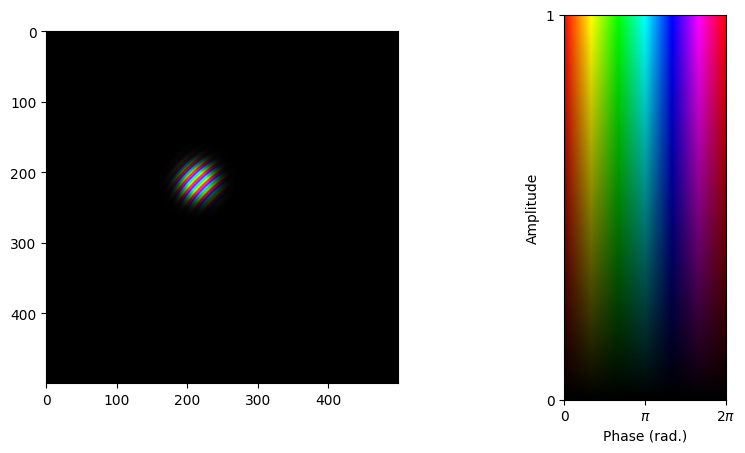

In [49]:
input_field = Field(gaussian_torch(500,0,0.05)).normalise().type(torch.cdouble).to(device)
test = TiltModel(z1=0.1).to(device)
test.forward(input_field, alpha=0.05, beta=0.05).detach().cpu().visualise()

In [15]:
Kz_gpu = Kz.to(device)
wl = 700e-9 #[m]

C:\Users\elija\AppData\Local\Temp\ipykernel_17364\966520539.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


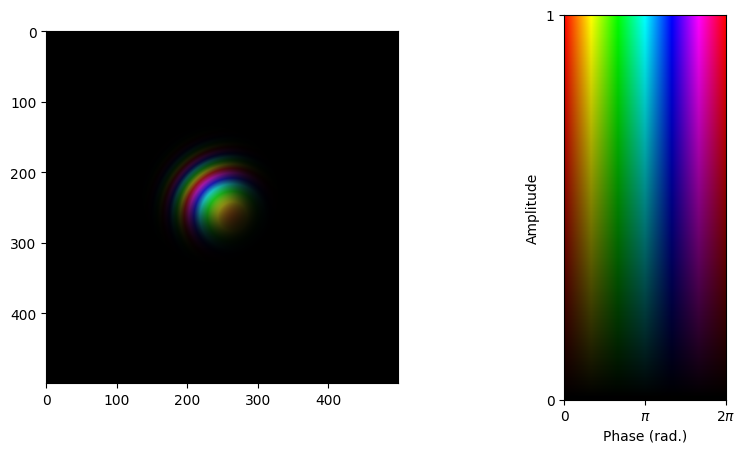

In [16]:
def tilt_forward(field_in, kz, z1, dist, alpha, beta, wl=700e-9):

    Nx = np.arange(-grid_size/2,grid_size/2,1)
    Ny = np.arange(-grid_size/2,grid_size/2,1)
    X,Y = np.meshgrid(Nx,Ny)
    X = torch.from_numpy(X)*pix_size
    Y = torch.from_numpy(Y)*pix_size

    field_before_mask = prop(field_in, kz, z1)
    field_after_mask = tilt2d(field_before_mask, X, Y, wl, alpha, beta)
    target_field = prop(field_after_mask, kz, (dist-z1))
    
    return target_field

input_field = Field(gaussian_torch(500,0,0.05)).normalise().type(torch.cdouble).to(device)
tilt_forward(input_field, Kz_gpu, 0.1, 0.3, alpha=0.05, beta=0.05).cpu().visualise()

In [17]:
input_field = Field(gaussian_torch(500,0,0.05)).normalise().type(torch.cdouble).to(device)
target = tilt_forward(input_field, Kz_gpu, 0.1, 0.3, alpha=0.05, beta=0.05)
test = TiltModel(z1=0.1).to(device)
output = test.forward(input_field, alpha=0.05, beta=0.05)
loss_fn(output, target).item()

1.124027432394133e-07

C:\Users\elija\AppData\Local\Temp\ipykernel_17364\966520539.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_17364\966520539.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


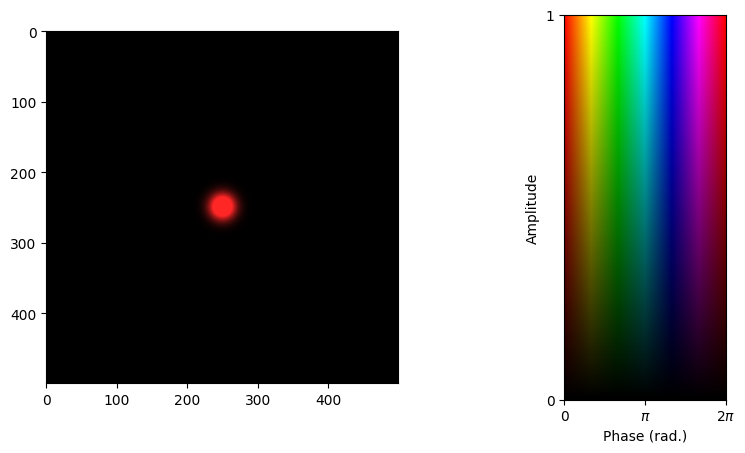

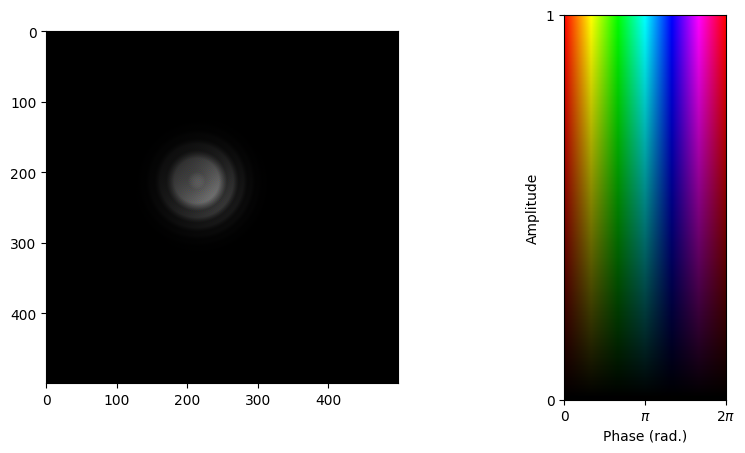

In [45]:
# Form training data (1 input, 1 target)
field_in = Field(gaussian_torch(500,0,0.05)).normalise().type(torch.cdouble).to(device)
field_in.cpu().visualise(title="Input Field")
field_before_mask = prop(field_in, Kz_gpu, 0.1)
#field_before_mask.cpu().visualise()
field_after_mask = tilt2d(field_before_mask, X, Y, wl, alpha=0.05, beta=0.05)
#field_after_mask.cpu().visualise()
target_field = prop(field_after_mask, Kz_gpu, 0.2)
target_field.cpu().visualise(title="Target Field")

In [19]:
input_field = Field(gaussian_torch(500,0,0.05)).normalise().type(torch.cdouble).to(device)
target_field = tilt_forward(input_field, Kz_gpu, 0.08, 0.3, alpha=0.05, beta=0.05)

In [50]:
# Training Loop
model = TiltModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 1000

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(field_in, alpha=0.05, beta=0.05)

    loss = loss_fn(y_pred, target_field)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, z1: {model.z1.item()}, z2: {0.3 - model.z1.item()}")

print(f"Final Loss: {loss.item()}")
print(f"Final z1: {model.z1.item()}")
print(f"Final z2: {0.3 - model.z1.item()}")

Epoch 0, Loss: 0.8301967535093726, z1: 0.14990000426769257, z2: 0.15009999573230742
Epoch 100, Loss: 0.8190806371462651, z1: 0.1412886530160904, z2: 0.1587113469839096
Epoch 200, Loss: 0.816974830644926, z1: 0.13694922626018524, z2: 0.16305077373981475
Epoch 300, Loss: 0.816805587977287, z1: 0.13557031750679016, z2: 0.16442968249320983
Epoch 400, Loss: 0.8168017809057371, z1: 0.13546927273273468, z2: 0.1645307272672653
Epoch 500, Loss: 0.8168017796883025, z1: 0.13546927273273468, z2: 0.1645307272672653
Epoch 600, Loss: 0.8168017825815646, z1: 0.13546866178512573, z2: 0.16453133821487426
Epoch 700, Loss: 0.8168017816118713, z1: 0.13546870648860931, z2: 0.16453129351139067
Epoch 800, Loss: 0.8168017797652158, z1: 0.1354687511920929, z2: 0.1645312488079071
Epoch 900, Loss: 0.8168017823666018, z1: 0.1354692429304123, z2: 0.1645307570695877
Final Loss: 0.8168017853090277
Final z1: 0.13546979427337646
Final z2: 0.16453020572662352


0
100
200
300
400


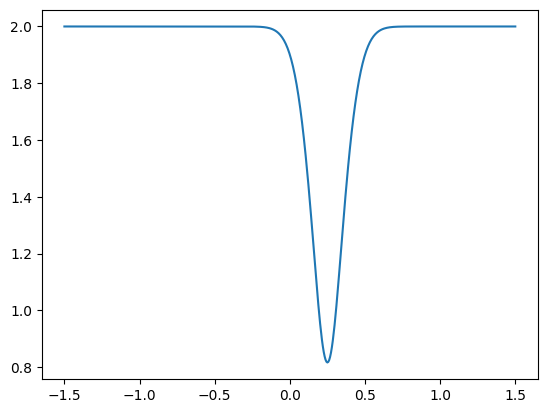

In [51]:
input_field = Field(gaussian_torch(500,0,0.05)).normalise().type(torch.cdouble).to(device)
#print(f"Input: {input_field.is_cuda}")
loss = []
xs = torch.from_numpy(np.linspace(-1.5,1.5,500))
target = tilt_forward(input_field, Kz_gpu, 0.1, 0.3, alpha=0.05, beta=0.05)
for i in range(xs.size()[0]):
    model = TiltModel(z1=xs[i]).to(device)
    #print(next(model.parameters()).is_cuda)
    y_pred = model(input_field, alpha=0.05, beta=0.05)
    #print(f"Target: {target.is_cuda}")
    loss.append(loss_fn(y_pred, target).cpu().detach().numpy())
    if i % 100 == 0:
        print(i)

plt.plot(xs,loss)

# Optimise using a dataset of 10
Want to make a random batch of gaussian input beams. (using a gaussian function with randomised inputs)

In [22]:
# Make a gaussian function
def gaussian(A, sigma, shape, mux=0, muy=0, warpx=0,warpy=0, B=0):
    """Makes a gaussian tensor of size = shape*shape. Intensity = A. Half-width = sigma. 
    Off-centre with 'mux' and 'muy' (-1 to +1). Or warp the shape with 'warpx' and 'warpy'."""
    X, Y = np.meshgrid(np.linspace((-1-mux)*(1+warpy), (1-mux)*(1+warpy), shape), np.linspace((-1+muy)*(1+warpx), (1+muy)*(1+warpx), shape))
    Z = (X**2 + Y**2)**0.5
    gauss = A * np.exp(-(Z**2)/(2*sigma**2)) + B
    return torch.from_numpy(gauss)

C:\Users\elija\AppData\Local\Temp\ipykernel_17364\966520539.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


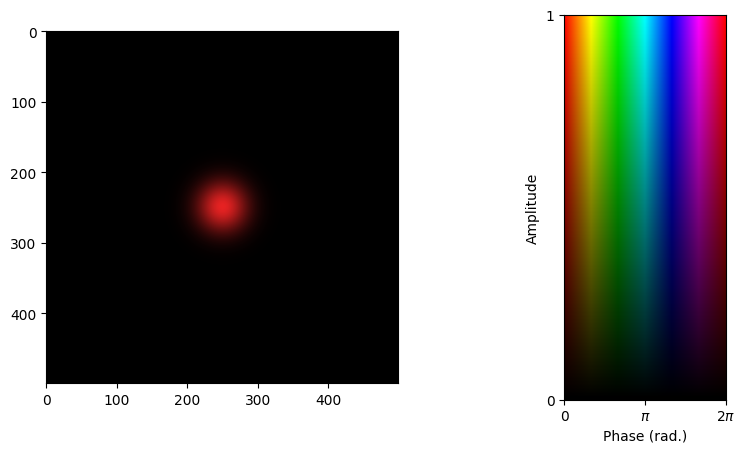

In [23]:
Field(gaussian(1, 0.1, 500)).normalise().visualise()                                                                                                                                                

In [24]:
# Make a function to generate a batch of random gaussian beams.
def rand_gauss_batch(batch: int=10, shape: int=500):
    """Generate random gaussian beams. batch = no. generated."""
    fields = []
    for i in range(batch):
        p1, p2, p3 = random.randrange(-1000,1000)/10000, random.randrange(-500,500)/1000, random.randrange(-500,500)/1000
        rand_gauss = Field(gaussian(1, p1, shape, p2, p3)).normalise().to(device)
        fields.append(rand_gauss)
    return fields

In [25]:
# Make 10 input gaussian fields
batch = 10
fields_in = rand_gauss_batch(batch)

# Make the target data
targets = []
for i in range(batch):
    targets.append(tilt_forward(fields_in[i], Kz_gpu, 0.2, 0.3, alpha=0.05, beta=0.05))

In [26]:
# Training Loop
model = TiltModel().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 1000

for epoch in range(epochs):
    optimiser.zero_grad()
    fields_out = []
    for field_in in fields_in:
        fields_out.append(model(field_in, alpha=0.05, beta=0.05))
    loss = loss_func(fields_out, targets)
    loss.backward()
    optimiser.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, z1: {model.z1.item()}, z2: {0.3 - model.z1.item()}")

print(f"Final Loss: {loss.item()}")
print(f"Final z1: {model.z1.item()}")
print(f"Final z2: {0.3 - model.z1.item()}")

Epoch 0, Loss: 0.22930874302125592, z1: 0.1501000076532364, z2: 0.1498999923467636
Epoch 100, Loss: 0.18546245523219074, z1: 0.16002589464187622, z2: 0.13997410535812377
Epoch 200, Loss: 0.141454864306215, z1: 0.17001034319400787, z2: 0.12998965680599212
Epoch 300, Loss: 0.09506369929226331, z1: 0.1802232712507248, z2: 0.1197767287492752
Epoch 400, Loss: 0.04641014053929831, z1: 0.19061554968357086, z2: 0.10938445031642913
Epoch 500, Loss: 0.0019344047665740484, z1: 0.2002507448196411, z2: 0.09974925518035888
Epoch 600, Loss: 0.00013096815645426447, z1: 0.19997525215148926, z2: 0.10002474784851073
Epoch 700, Loss: 2.191877643122059e-05, z1: 0.19999215006828308, z2: 0.10000784993171691
Epoch 800, Loss: 8.873974721000248e-05, z1: 0.20000997185707092, z2: 0.09999002814292907
Epoch 900, Loss: 7.409937106993977e-05, z1: 0.19998972117900848, z2: 0.1000102788209915
Final Loss: 5.753503218602984e-05
Final z1: 0.2000041902065277
Final z2: 0.09999580979347228


0
100
200
300
400


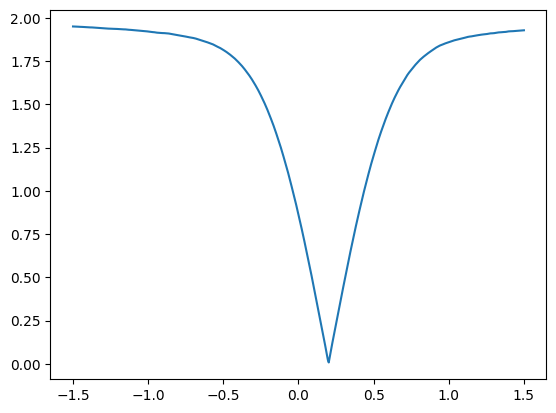

In [27]:
#input_field = Field(gaussian_torch(500,0,0.05)).normalise().type(torch.cdouble).to(device)
#print(f"Input: {input_field.is_cuda}")
loss = []
xs = torch.from_numpy(np.linspace(-1.5,1.5,500))
#target = tilt_forward(input_field, Kz_gpu, 0.1, 0.3, alpha=0.05, beta=0.05)
for i in range(xs.size()[0]):
    model = TiltModel(z1=xs[i]).to(device)
    #print(next(model.parameters()).is_cuda)
    fields_out = []
    for field_in in fields_in:
        fields_out.append(model(field_in, alpha=0.05, beta=0.05))
    #y_pred = model(input_field)
    #print(f"Target: {target.is_cuda}")
    loss.append(loss_func(fields_out, targets).cpu().detach().numpy())
    if i % 100 == 0:
        print(i)

plt.plot(xs,loss)

In [28]:
# Make 10 random tilt phase masks (within reasonable ranges) and try to optimise a NN model with them as training data.
def rand_phase_tilt(batch: int, X: torch.Tensor, Y: torch.Tensor, wl:float) -> torch.Tensor:
    """Text"""
    masks = []
    for _ in range(batch):
        alpha, beta = random.randrange(-1000,1000)/1000, random.randrange(-1000,1000)/1000
        masks.append(tilt_phase_mask(X, Y, wl, alpha, beta))
    return masks

# Want it to work with the tilt_forward function, so will only generate the alpha and beta randomly
def rand_alpha(batch: int=10) -> list:
    """Generates a list of size 'batch' of alpha angle values."""
    alpha = []
    for _ in range(batch):
        alpha.append(random.randrange(-1000,1000)/10000)
    return alpha
    
def rand_beta(batch: int=10) -> list:
    """Generates a list of size 'batch' of alpha angle values."""
    beta = []
    for _ in range(batch):
        beta.append(random.randrange(-1000,1000)/10000)
    return beta

In [29]:
# Generate alphas and betas
batch = 10
alphas = rand_alpha(batch)
betas = rand_beta(batch)

# Input gaussian beam
field_in = Field(gaussian(1, 0.1, 500)).normalise().to(device)

# Make target data
targets = []
for i in range(batch):
    targets.append(tilt_forward(field_in, Kz_gpu, 0.1, 0.3, alpha=alphas[i], beta=betas[i]))

In [30]:
# Training Loop
model = TiltModel().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 1000

for epoch in range(epochs):
    optimiser.zero_grad()
    fields_out = []
    for i in range(batch):
        fields_out.append(model(field_in, alpha=alphas[i], beta=betas[i]))
    loss = loss_func(fields_out, targets)
    loss.backward()
    optimiser.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, z1: {model.z1.item()}, z2: {0.3 - model.z1.item()}")

print(f"Final Loss: {loss.item()}")
print(f"Final z1: {model.z1.item()}")
print(f"Final z2: {0.3 - model.z1.item()}")

Epoch 0, Loss: 0.24244188189521357, z1: 0.14990000426769257, z2: 0.15009999573230742
Epoch 100, Loss: 0.19431009416902204, z1: 0.13988886773586273, z2: 0.16011113226413726
Epoch 200, Loss: 0.14578304186084148, z1: 0.12985245883464813, z2: 0.17014754116535186
Epoch 300, Loss: 0.09697161192355666, z1: 0.11979998648166656, z2: 0.18020001351833342
Epoch 400, Loss: 0.04799106843758343, z1: 0.10974123328924179, z2: 0.1902587667107582
Epoch 500, Loss: 0.0007594292641695778, z1: 0.09979826956987381, z2: 0.20020173043012618
Epoch 600, Loss: 3.843224228108748e-05, z1: 0.09998572617769241, z2: 0.20001427382230758
Epoch 700, Loss: 1.4448437995434133e-05, z1: 0.10000137984752655, z2: 0.19999862015247344
Epoch 800, Loss: 3.991489481791632e-05, z1: 0.09999135881662369, z2: 0.2000086411833763
Epoch 900, Loss: 8.2213610123342e-05, z1: 0.10000360012054443, z2: 0.19999639987945556
Final Loss: 0.00011201168545170845
Final z1: 0.09998807311058044
Final z2: 0.20001192688941954


0
100
200
300
400


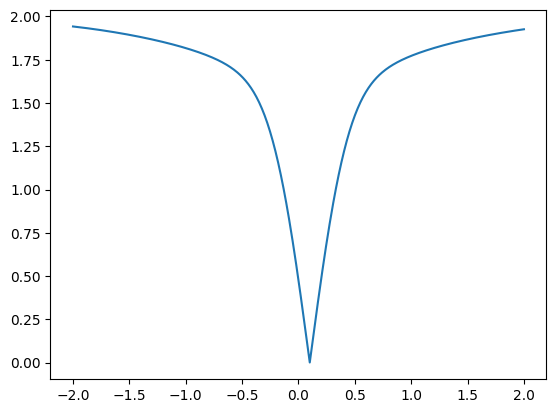

In [31]:
loss = []
xs = torch.from_numpy(np.linspace(-2,2,500))

for i in range(xs.size()[0]):
    model = TiltModel(z1=xs[i]).to(device)
    fields_out = []
    if i % 100 == 0:
        print(i)
    for j in range(batch):
        fields_out.append(model(field_in, alpha=alphas[j], beta=betas[j]))
    loss.append(loss_func(fields_out, targets).cpu().detach().numpy())

plt.plot(xs,loss)

In [32]:
def frenel_forward(field_in, kz, z1, dist, f, wl=700e-9):

    Nx = np.arange(-grid_size/2,grid_size/2,1)
    Ny = np.arange(-grid_size/2,grid_size/2,1)
    X,Y = np.meshgrid(Nx,Ny)
    X = torch.from_numpy(X)*pix_size
    Y = torch.from_numpy(Y)*pix_size    

    field_before_mask = prop(field_in, kz, z1)
    field_after_mask = frenel2d(field_before_mask, X, Y, wl, f)
    target_field = prop(field_after_mask, kz, (dist-z1))

    return target_field

def rand_focus(batch: int=10) -> list:
    """Generates 'batch' number of focal lengths."""
    focus = []
    for _ in range(batch):
        focus.append(random.randrange(5, 100)/100)
    return focus

In [33]:
# Generate training data
batch = 50
fs = rand_focus(batch)

# Input gaussian beam
field_in = Field(gaussian(1, 0.1, 500)).normalise().to(device)

# Make target data
targets = []
for i in range(batch):
    targets.append(frenel_forward(field_in, Kz_gpu, 0.1, 0.3, f=fs[i]))

In [34]:
# Training Loop
model = FrenelModel().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 1000

for epoch in range(epochs):
    optimiser.zero_grad()
    fields_out = []
    for i in range(batch):
        fields_out.append(model(field_in, fs[i]))
    loss = loss_func(fields_out, targets)
    loss.backward()
    optimiser.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, z1: {model.z1.item()}, z2: {0.3 - model.z1.item()}")

print(f"Final Loss: {loss.item()}")
print(f"Final z1: {model.z1.item()}")
print(f"Final z2: {0.3 - model.z1.item()}")

Epoch 0, Loss: 0.29035898252023773, z1: 0.14990000426769257, z2: 0.15009999573230742
Epoch 100, Loss: 0.22803295312752891, z1: 0.13981738686561584, z2: 0.16018261313438414
Epoch 200, Loss: 0.16673929280378186, z1: 0.12985433638095856, z2: 0.17014566361904143
Epoch 300, Loss: 0.109575657697266, z1: 0.1201750785112381, z2: 0.1798249214887619
Epoch 400, Loss: 0.05657388009939207, z1: 0.11076336354017258, z2: 0.1892366364598274
Epoch 500, Loss: 0.009279375804651607, z1: 0.10175921767950058, z2: 0.1982407823204994
Epoch 600, Loss: 1.3153826186123293e-05, z1: 0.09999334067106247, z2: 0.20000665932893752
Epoch 700, Loss: 1.2261895323682055e-05, z1: 0.09999296069145203, z2: 0.20000703930854796
Epoch 800, Loss: 1.092400064022767e-05, z1: 0.0999925434589386, z2: 0.2000074565410614
Epoch 900, Loss: 9.437447378278135e-06, z1: 0.09999212622642517, z2: 0.20000787377357482
Final Loss: 1.0337345969782412e-05
Final z1: 0.10000156611204147
Final z2: 0.19999843388795852


0
100
200
300
400


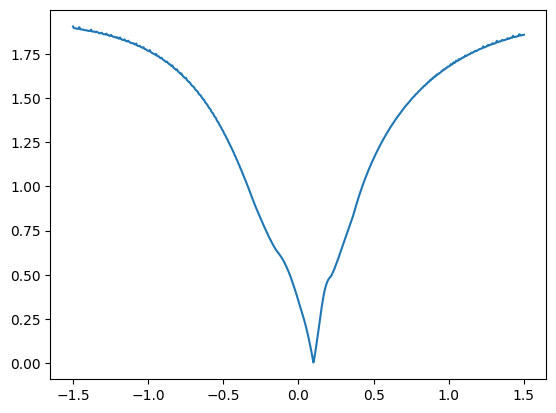

In [35]:
loss = []
xs = torch.from_numpy(np.linspace(-1.5,1.5,500))

for i in range(xs.size()[0]):
    model = FrenelModel(z1=xs[i]).to(device)
    fields_out = []
    if i % 100 == 0:
        print(i)
    for j in range(batch):
        fields_out.append(model(field_in, fs[j]))
    loss.append(loss_func(fields_out, targets).cpu().detach().numpy())

plt.plot(xs,loss)

# Lateral Misalignments
Model the phase masks being laterally misaligned in the x and y directions. 

Want the optimiser to return the misalignment in terms of pixels (easiest to check if correct)

C:\Users\elija\AppData\Local\Temp\ipykernel_17364\966520539.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


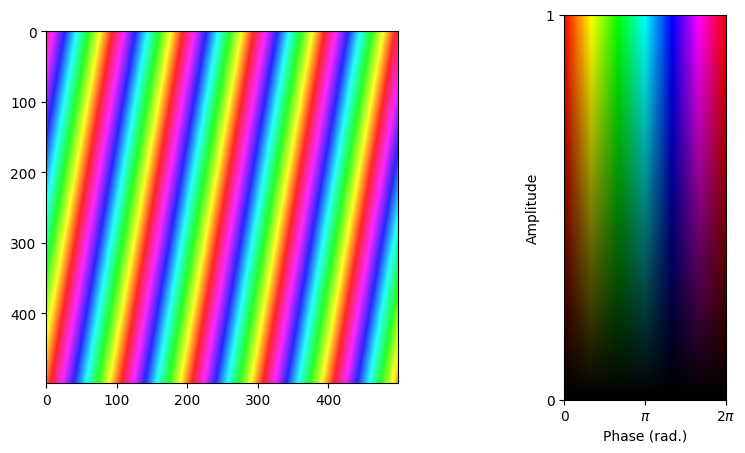

In [36]:
# Generate a tilt phase mask for reference
alpha = 0.04
beta = 0.007
Nx = np.arange(-grid_size/2,grid_size/2,1)
Ny = np.arange(-grid_size/2,grid_size/2,1)
X,Y = np.meshgrid(Nx,Ny)
Xp = torch.from_numpy(X)*pix_size
Yp = torch.from_numpy(Y)*pix_size
tilt_mask = Field(tilt_phase_mask(Xp,Yp,700e-9,alpha=alpha,beta=beta))
tilt_mask.visualise(figsize=(10,5))

C:\Users\elija\AppData\Local\Temp\ipykernel_17364\966520539.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


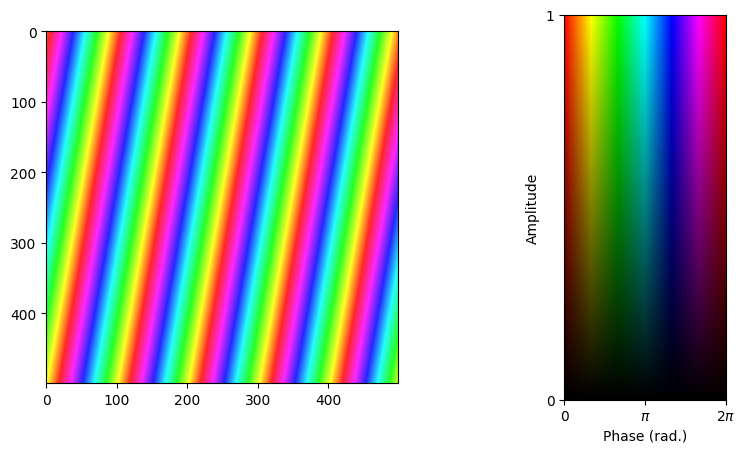

In [37]:
testx = Xp+(75*pix_size)
testy = Yp+(75*pix_size)

tilt_mask = Field(tilt_phase_mask(testx,testy,700e-9,alpha=alpha,beta=beta))
tilt_mask.visualise(figsize=(10,5))

C:\Users\elija\AppData\Local\Temp\ipykernel_17364\966520539.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_17364\966520539.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


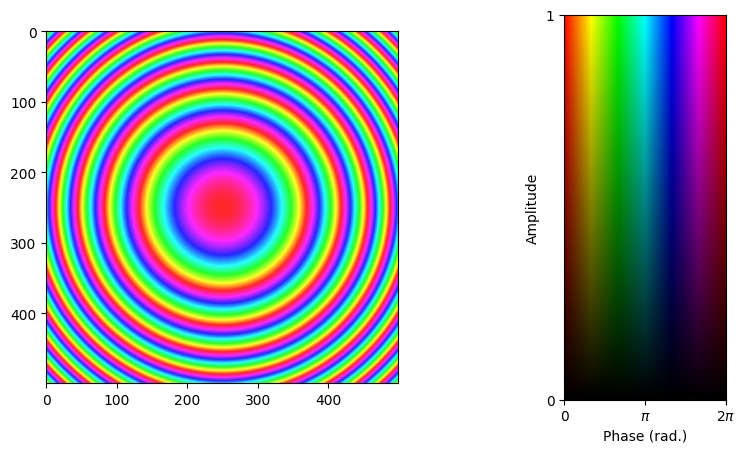

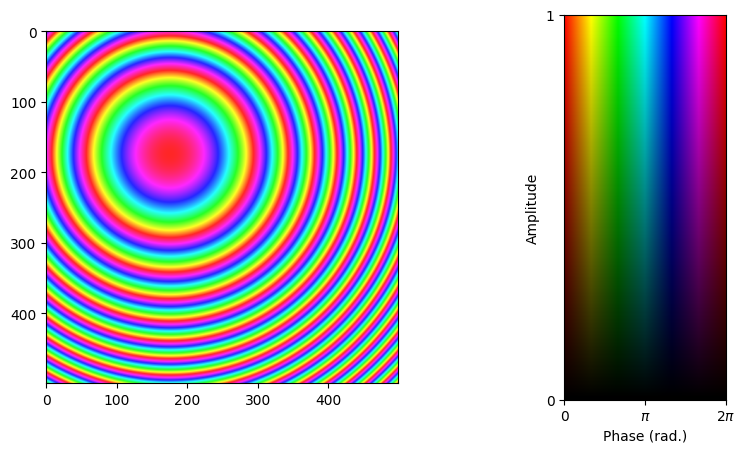

In [38]:
f = 1 #[m]
frenel_mask = Field(frenel_lens_mask(Xp,Yp,wl,f))
frenel_mask.visualise()

frenel_mask_mis = Field(frenel_lens_mask(testx,testy,wl,f))
frenel_mask_mis.visualise()